Python implementation of the Image Resolution Estimation algorithm by A. Descloux et al. 

>Descloux, A., K. S. Grußmayer, et A. Radenovic. _Parameter-Free Image Resolution Estimation Based on Decorrelation Analysis_. Nature Methods 16, nᵒ 9 (septembre 2019): 918‑24. https://doi.org/10.1038/s41592-019-0515-7.

Original source code in matlab™ and ImageJ plugin are available [here](https://github.com/Ades91/ImDecorr)


In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.signal import general_gaussian, find_peaks

from scipy.fft import fft2

from scipy.fft import fftshift, ifft2, ifftshift

from skimage import img_as_float

In [2]:
# apodImRect.m
def apodise(image, border, order=8):
    """
    Parameters
    ----------
    
    image: np.ndarray 
    border: int, the size of the boreder in pixels
    
    Note
    ----
    The image is assumed to be of float datatype, no datatype management
    is performed.
    
    This is different from the original apodistation method,
    which multiplied the image borders by a quater of a sine.
    """
    # https://stackoverflow.com/questions/46211487/apodization-mask-for-fast-fourier-transforms-in-python
    nx, ny = image.shape
    # Define a general Gaussian in 2D as outer product of the function with itself
    window = np.outer(
        general_gaussian(nx, 8, nx//2-border),
        general_gaussian(ny, 8, ny//2-border))
    ap_image = window*image
    
    return ap_image


In [3]:
def test_apodise():

    image = np.random.random((800, 600))
    ap_image = apodise(image, 60)
    assert ap_image.shape == image.shape
    
    assert ap_image[:, 0].mean() < 1e-3
    assert ap_image[0, :].mean() < 1e-3
    np.testing.assert_array_almost_equal(
        ap_image[400:410, 300:310],
        image[400:410, 300:310], decimal=3
    )
        

In [4]:
def get_correlation_coefficient(im_fft1, im_fft2, c1=None, c2=None):
    if c1 is None:
        c1 = np.linalg.norm(im_fft1)
    if c2 is None:
        c2 = np.linalg.norm(im_fft2)
    return (im_fft1 * im_fft2.conjugate()).real.sum() / (c1*c2)


In [5]:
def test_cor_coeff():
    im1 = np.random.random([1000, 1000])
    im2 = np.random.random([1000, 1000])
    im_fft1 = fft2(im1)
    im_fft2 = fft2(im2)
    np.testing.assert_almost_equal(
        np.linalg.norm(np.abs(im_fft1)), np.linalg.norm(im_fft1)
    )
    np.testing.assert_approx_equal(
        get_correlation_coefficient(im_fft1, im_fft2),
        0.75, significant=2
    )
    np.testing.assert_approx_equal(
        get_correlation_coefficient(im_fft1, im_fft1),
        1.0, significant=5
    )
    np.testing.assert_approx_equal(
        get_correlation_coefficient(im_fft1, fft2(1 - im1)),
        0.5, significant=3
    )

test_cor_coeff()


%  im        	2D image to be analyzedthreshold
%  r           	Fourier space sampling of the analysis (default: r = linspace(0,1,50)
%  Ng			Number of high-pass filtering (default: Ng = 10)
                                                        


In [6]:
!ls ../../samples/

organ-of-corti.tif


In [7]:
from skimage.io import imread

In [8]:
corti = img_as_float(imread('../../samples/organ-of-corti.tif'))

corti = corti[0, ..., 0]

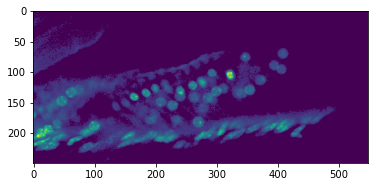

In [9]:
plt.imshow(corti)

In [10]:
corti.shape

(249, 548)

In [11]:

image = apodise(corti, 30, order=8)

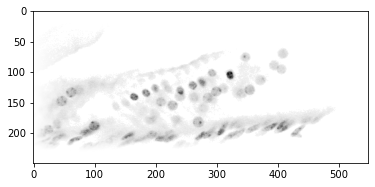

In [12]:
plt.imshow(image, cmap='Greys')

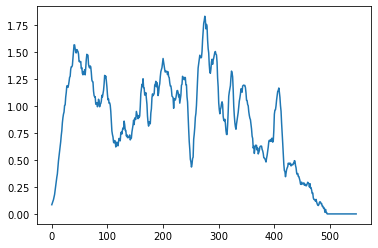

In [13]:

plt.plot(image.sum(axis=0))

In [33]:
from scipy.ndimage import gaussian_filter
from dataclasses import dataclass
from scipy.optimize import minimize_scalar


def _fft(image):
    """shifted fft
    """
    return fftshift(fft2(fftshift(image)))

def _ifft(im_fft):
    """shifted ifft
    """
    return ifftshift(ifft2(ifftshift(im_fft)))


class CorrImage:

    
    Nr : int = 100
    pic_threshold : float = 1e-5
    pod_size = 30
    pod_order = 8
    
    def __init__(self, image):
        
        self.image = apodise(image, self.pod_size, self.pod_order)
        nx, ny = self.image.shape
        
        # odd number of pixels
        nx, ny = nx - (1 - nx%2), ny - (1 - ny%2)
        self.image = self.image[:nx, :ny]
        self.size = nx * ny
        xx, yy = np.meshgrid(np.linspace(-1, 1, ny), np.linspace(-1, 1, nx))
        
        self.disk = (xx**2 + yy**2)
        self.mask0 = self.disk < 1.0
        
        im_fft0 = _fft(self.image)
        im_fft0 /= np.abs(im_fft0)
        im_fft0[~np.isfinite(im_fft0)] = 0
       
        self.im_fft0 = im_fft0 * self.mask0 # I in original code

        image_bar = (self.image - self.image.mean())/self.image.std()
        im_fftk = _fft(image_bar) * self.mask0  # Ik
        
        self.im_invk = _ifft(im_fftk).real # imr
        self.im_fftr = (_fft(self.im_invk) * self.mask0).ravel()[:self.size // 2] # Ir
        
    
    def corcoef(self, radius, im_fftr, c1=None):
        im_fft_ = ((self.disk < radius) * self.im_fft0).ravel()[:self.size //2]
        return get_correlation_coefficient(im_fftr, im_fft_, c1=c1)
    
    def maximize_corcoef(self, im_fftr):
        
        def anti_cor(radius):
            c1 = np.linalg.norm(im_fftr)
            if radius > 1.:
                return 1.
            if radius < 1e-5:
                return 1.
            
            cor = self.corcoef(radius, im_fftr, c1=c1)
            return 1 - cor

        res = minimize_scalar(
            anti_cor,
            bounds=(0, 1),
            method='bounded',
            options={"xatol": 1e-3}
        )
        
        if not res.success:
            return {"snr": 0.0, "resolution": 0.0}
        
        if (1 - res.x) < 1e-4:
            return {"snr": 0.0, "resolution": 0.0}
            
        return {"snr": res.fun, "resolution": res.x}
    
    def all_corcoefs(self, im_fftr, num_rs, r_min=0, r_max=1, num_ws=0):
        
        radii = np.linspace(r_min, r_max, num_rs)
        c = np.linalg.norm(im_fftr)
        
        d0 =  np.array([
            self.corcoef(radius, im_fftr, c1=c) for radius in radii
        ])
        if not num_ws:
            return radii, d0
        ds = [d0]
        for width in np.logspace(np.log10(40), np.log10(0.15), num_ws):
            
            f_im = self.im_invk - gaussian_filter(self.im_invk, width)
            f_im_fft = (self.mask0 * _fft(f_im)).ravel()[:self.size//2]
            c1 = np.linalg.norm(f_im_fft)
            d =  np.array([
                self.corcoef(radius, f_im_fft, c1=c) for radius in radii
            ])
            ds.append(d)
        return radii, ds
        
    def decor_rad(self, width):
        
        f_im = self.im_invk - gaussian_filter(self.im_invk, width)
        f_im_fft = (self.mask0 * _fft(f_im)).ravel()[:self.size//2]
        res = self.maximize_corcoef(f_im_fft)
        self.evals.append([res["snr"], res['resolution']])
        return 1 - res["resolution"]

    def decorr_radius(self):
        self.evals = []

        res = minimize_scalar(
            self.decor_rad,
            bounds=(0, 0.9),
            method='bounded',
            options={"xatol": 1e-3}
        )
        
        return res
    
    
        

In [34]:
ci = CorrImage(corti)

In [35]:
res = ci.maximize_corcoef(ci.im_fftr)

In [36]:
res

{'snr': 0.3831568881369075, 'resolution': 0.012488950444443633}

In [37]:
ci.decorr_radius()

     fun: 0.00039978928100126154
 message: 'Solution found.'
    nfev: 15
  status: 0
 success: True
       x: 0.8993401763077284

In [20]:
data = []
for width in np.logspace(-1, 2):
    
    f_im = ci.im_invk - gaussian_filter(ci.im_invk, width)
    f_im_fft = (ci.mask0 * _fft(f_im)).ravel()[:ci.size//2]
    res = ci.maximize_corcoef(f_im_fft)
    res['width'] = width
    data.append(res)

/home/guillaume/miniconda3/envs/ijpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [22]:
data = np.array([list(d.values()) for d in data])

Text(0, 0.5, 'snr')

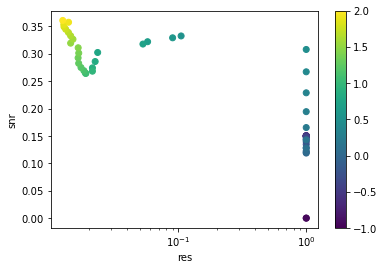

In [32]:
fig, ax = plt.subplots()
sc = ax.scatter(data[:, 1], data[:, 0], c=np.log10(data[:, 2]))
cb = fig.colorbar(sc)
#ax.set_xlim(0.001, 0.2)
ax.set_xscale('log')
ax.set_xlabel("res")
ax.set_ylabel("snr")

In [29]:
cb.ax

In [364]:
res

{'snr': 0.36068485740483625,
 'resolution': 0.012473656856960948,
 'width': 100.0}

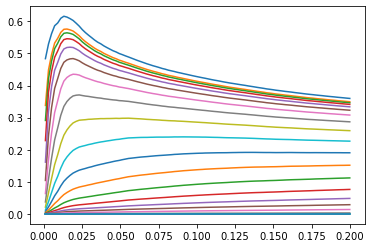

In [365]:
rs, ds = ci.all_corcoefs(ci.im_fftr, 100, 0.001, 0.2, num_ws=20)



for d in ds:
    plt.plot(rs, d)


In [60]:
res

      fun: -991266040.3140377
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.1])

In [136]:
from scipy.ndimage import gaussian_filter


#(input, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
Nr = 100
pic_threshold = 1e-5

radius = np.linspace(1/Nr, 1, Nr)
nx, ny = image.shape
# odd number of pixels
nx, ny = nx - (1 - nx%2), ny - (1 - ny%2)
image = image[:nx, :ny]

xx, yy = np.meshgrid(np.linspace(-1, 1, ny), np.linspace(-1, 1, nx))
dist2 = (xx**2 + yy**2)
mask0 = dist2 < 1.


I = fftshift(fft2(fftshift(image)))
I /= np.abs(I)
I[~np.isfinite(I)] = 0

# restric all the analysis to the region r <= 1
I *= mask0

image_bar = (image - image.mean())/image.std()
Ik = fftshift(fft2(fftshift(image_bar)))
Ik *= mask0

imr = ifftshift(
    ifft2(
        ifftshift(Ik)
    )
).real

imt = imr
Ir = mask0*fftshift(fft2(fftshift(imt)))
Ir = Ir.ravel()[:(nx*ny)//2]

# possible optim:
# Ir.ravel().imag == -Ir.ravel().imag[:-(nx*ny)//2:-1]

c = np.linalg.norm(Ir)
d0 = np.array([
    get_correlation_coefficient(Ir, ((dist2 < rt)*I).ravel()[:(nx*ny)//2], c1=c)
    for rt in radius
])

def find_max_corr(d, threshold):
    pos, _ = find_peaks(d, threshold=threshold)
    if not pos.size:
        pos = -1
    elif pos.size == 1:
        pos = pos[0]
    else:
        warnings.warn("Equivocal value for the correlation maximum")
        ds = d[pos]
        top = ds.argmax()
        pos = pos[top]
    return pos

pos0 = find_max_corr(d0, pic_threshold)
snr0 = d0[pos0]
res0 = radius[pos0]


# Automatic search of best geometric mean (?)
gMax = 30 #2/res0
Ng = 10

dg = []
maxes = []
snrs = []
res = []
gauss_freqs = np.logspace(np.log10(gMax), np.log10(0.15), Ng)

for width in gauss_freqs:
    imt = imr - gaussian_filter(imr, width)
    Ir_ = (mask0 * fftshift(fft2(fftshift(imt)))).ravel()[:nx*ny//2]
    c = np.linalg.norm(Ir_)
    d = np.array([
            get_correlation_coefficient(Ir_, ((dist2 < rt)*I).ravel()[:nx*ny//2], c1=c)
            for rt in radius
        ])
    dg.append(d)
    pos = find_max_corr(d, pic_threshold)
    maxes.append(pos)
    snrs.append(d[pos])
    res.append(radius[pos])


/home/guillaume/miniconda3/envs/ijpy/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Equivocal value for the correlation maximum


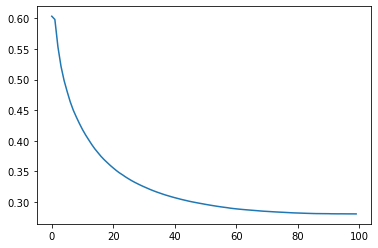

In [137]:
plt.plot(d0)

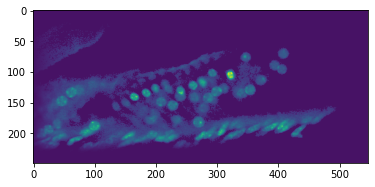

In [113]:
plt.imshow(imr)

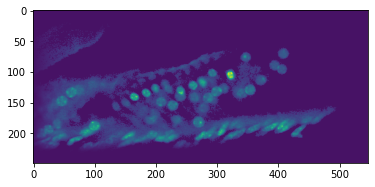

In [114]:
plt.imshow(ci.im_invk)

In [124]:
np.abs(ci.im_invk - imr).max()

0.0

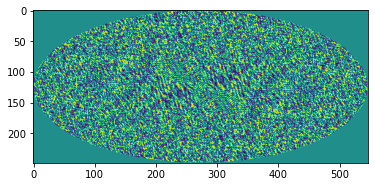

In [115]:
plt.imshow(I.real)

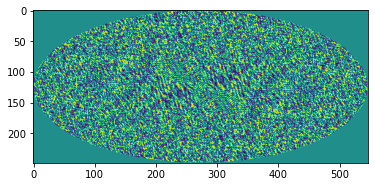

In [116]:
plt.imshow(ci.im_fft0.real)

In [142]:
(Ir - ci.im_fftr).imag.max()

0.0

In [ ]:
plt.plot(Ir)

In [101]:

(ci.im_fft0 - I).real.min()

0.0

/home/guillaume/miniconda3/envs/ijpy/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


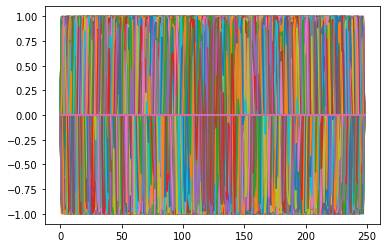

In [90]:
plt.plot(I)

In [79]:
ci.im_invk.max()

9.354929397124254

In [80]:
imr.max()

9.355100220031236

In [81]:
imr.min()

-1.0307818912679632

In [82]:
ci.im_invk.min()

-6.781199025962645

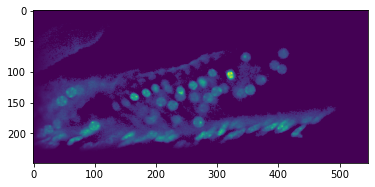

In [83]:
plt.imshow(image)

In [88]:
(image - ci.image).max()

0.0

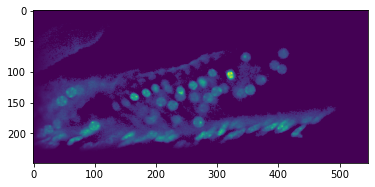

In [86]:
plt.imshow(ci.image)

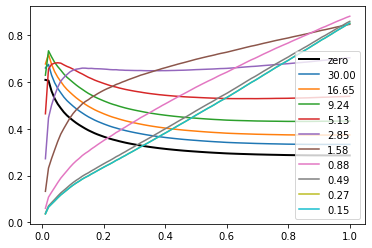

In [31]:
dg = np.array(dg)

fig, ax = plt.subplots()
ax.plot(radius, d0, 'k-', label='zero', lw=2)
for d, freq in zip(dg, gauss_freqs):
    
    ax.plot(radius, d, label=f'{freq:.2f}')

ax.legend()

In [18]:
snrs = np.array(snrs)
maxes = np.array(maxes)
res = np.array(res)

In [19]:
snrs

array([0.78524365, 0.84620903, 0.87762719, 0.87950238, 0.86731301,
       0.85770726, 0.85180611, 0.85020245, 0.85011854, 0.8501181 ])

In [20]:
maxes

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [21]:
res

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

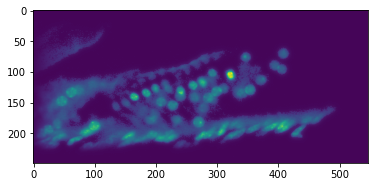

In [71]:
plt.imshow(imt)

```octave
% automatic search of best geometric mean
g = exp(linspace(log(gMax),log(0.15),Ng));
d = []; kc = []; SNR = []; gm = []; dc = 1;

for refin = 1:2 % two step refinement
for h = 1:length(g)
    imt = imr - imgaussfilt(imr,g(h));
    Ir = mask0.*fftshift(fftn(fftshift(imt)));
    Ir = Ir(1:(end-1)/2);
    c = sqrt(sum(sum(abs(Ir).^2)));
    for k = length(r):-1:1
        rt = r(k);
        mask  = X.^2 + Y.^2 < rt^2;
        temp = mask.*I;
        temp = temp(1:(end-1)/2); % remove the mean
%         cc = sum(sum(abs(Ir.*temp)))/(c.*sqrt(sum(sum(abs(temp).^2)))); % compute the correlation coeficient
        cc = getCorrcoef(Ir,temp,c);
        if isnan(cc); cc = 0; end
        d(k,dc) = gather(cc); % gather if input image is gpuArray
        count = count+1;
        if figID
            waitbar(0.1 + 0.9*count/(Nr*Ng*2),hwait);
        end
    end
    dc = dc + 1;
    [ind,snr] = getDcorrMax(d(:,end));
    kc(end+1) = r(ind);
    SNR(end+1) = snr;
    gm(end+1) = sqrt(snr*r(ind)); % 
end
```

In [64]:
res0

0.012

In [65]:
snr0

0.6116782291903357

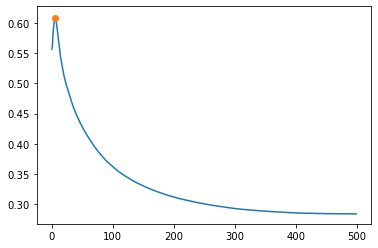

In [66]:
fig, ax = plt.subplots()
ax.plot(d0)
ax.plot(pos, d0[pos], 'o')

```octave
function [ind,A] = getDcorrMax(d)

[A,ind] = max(d);
t = d;
% arbitrary peak significance parameter imposed by numerical noise
% this becomes relevant especially when working with post-processed data
dt = 0.001;

while ind == length(t)
    t(end) = [];
    if isempty(t)
        A = 0;
        ind = 1;
    else
        [A,ind] = max(t);
        % check if the peak is significantly larger than the former minimum
        if t(ind) - min(d(ind:end)) > dt 
            break
        else
            t(ind) = min(d(ind:end));
            ind = length(t);
        end
    end
```     


```octave
[X,Y] = meshgrid(linspace(-1,1,size(im,2)),linspace(-1,1,size(im,1)));
Nr = length(r);

I = fftshift(fftn(fftshift(im))); I = I./abs(I); I(isinf(I)) = 0; I(isnan(I)) = 0;
mask0 = X.^2 + Y.^2 < 1^2;
I = mask0.*I; % restric all the analysis to the region r == 1

Ik = mask0.*fftshift(fftn(fftshift((im-mean(im(:)))/std(im(:)))));
imr = real(ifftshift(ifftn(ifftshift(Ik))));
```

In [47]:
fftshift(image)

array([[0.67074799, 0.83671364, 0.25276363, ..., 0.19642213, 0.58379736,
        0.21906116],
       [0.59398047, 0.82944432, 0.34915216, ..., 0.71289157, 0.84588396,
        0.67555132],
       [0.63400142, 0.27897325, 0.96001238, ..., 0.22407383, 0.69553334,
        0.47816803],
       ...,
       [0.65119477, 0.07653379, 0.48667962, ..., 0.57571926, 0.55755134,
        0.03168877],
       [0.71385308, 0.37119132, 0.21414192, ..., 0.67157937, 0.42736937,
        0.84743655],
       [0.70361153, 0.68760876, 0.4406447 , ..., 0.16073305, 0.19318633,
        0.85689938]])